# Environment setup

In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Library preparation

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
from si_prefix import si_format
from math import *
from tqdm import tqdm, tqdm_notebook

from io import StringIO 
import pandas as pd
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

from JJ_data_processing import *
from JJformulas import *

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment, experiments)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


### Database ini

In [4]:
SAMPLE = 'D078N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

## Scripts

### Data proc

In [5]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [6]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [7]:
def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [8]:
def batch_plot_by_id(ids, ax = None, labels = None, **kw):
    if ax is None:
        fig, ax = plt.subplots()
        
    for i, idx in enumerate(ids):
        if labels is not None:
            label = labels[i]
        else:
            label = ''
            
        plot_by_id(idx, axes = ax, label = label, **kw)
        
    ax.legend()
    

In [ ]:
def selId (runidlst = range(164,209+1), evenNum = True):
    """
    help to select even or odd number from a int list.
    can be use to select run id has alternating measurements such as plus-scan and minus scan.

    runidlst: int list that has continuous number, or, range-like structure
    evenNum: select either even number or odd number
    a[b]: the resulting list contains only even or odd numbers, half the length of input runidlst
    """
   
    a = np.array(runidlst)
    b = np.array(range(0,int(len(a)/2)))*2
    if a[0]%2 == 0:
        if evenNum:
            b = b
        else:
            b = b+1
    else:
        if evenNum:
            b = b+1
        else:
            b = b
    return a[b]

In [9]:
def JJpar(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34):
   
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
   
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
    EJoEc = EJ_JJ/min(EC0,EC_JJ)

#     key =  [ 'RN_JJ',   'Rs_JJ', 'I_AB',   'EJ', 'C_JJQP',   'EC', 'C0', 'EC0', 'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
#     unit=  [   'ohm', 'ohm-m^2',    'A',    'J',      'F',    'J',  'F',   'J',          'Hz',  '',     '',      '']
#     lst = [[     RN ,    Rs_JJ ,   IAB , EJ_JJ ,    C_JJ , EC_JJ ,  C0 ,  EC0 ,    freqPlasma,  Q ,   Q*Q ,  EJoEc ]]
    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',    'C0',       'EC0',  'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',    'fF',         'K',          'GHz',  '',     '',      '']
    lst = [[ RN/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, C0*1e15, EC0/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM =   pd.DataFrame(  data  = list(zip(*lst)),
                                index = key ).transpose()
    JJparUNI =   dict(zip(key, unit))

    return JJparDFM,JJparUNI

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    C = epsilon *area /dielecTHK
    return C

In [ ]:
def cos_to_B(cos, ZF = .004e-3, FF = .232e-3):
    return np.arccos(cos)*(2* (FF - ZF)/np.pi + ZF  )

#### Exps

In [11]:
FF_ = .230e-3
ZF_ = -.00e-3

def populate_exps (exps,ZF_ = .004e-3, FF_ = .232e-3, VERBOSE = False):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws = []
        R0s = []

        if VERBOSE:
            fig, ax = plt.subplots()

        Is = []
        Vs = []

        Irs = []
        Vrs = []

        Ils = []
        Vls = []

        for i in exp['ids']:

            I, V = xy_by_id(i)

            Tb = exp['T']

            ind_Vmax = np.argmax(I)
            ind_Vmin = np.argmin(I)

            ind_I0 = np.argmin(abs(I - 0e-12))
            ind_near0 = np.where(abs(I) > 0e-9)

            V_off = np.mean(V[ind_near0])
            V -= V_off

            I, V = cut_dxdy(I, V, dx = 250e-9 ,dy = 10e-6)

            V_off = np.mean(V)
            V -= V_off

    
            g0 = np.where(I>0)
            l0 = np.where(I<0)

            Ir, Vr = I[g0], V[g0]
            Il, Vl = I[l0], V[l0]


            if VERBOSE:
                ax.plot(I,V, 'o')

            Isw, R0 = extract_Isw_R0 (I,V)
            Isws.append(Isw)
            R0s.append(R0)


            Is.append(I)
            Vs.append(V)

            Irs.append(Ir)
            Vrs.append(Vr)

            Ils.append(Il)
            Vls.append(Vl)



        exp ['Is' ] =  Is
        exp ['Vs' ] =  Vs

        exp ['Irs' ] =  Irs
        exp ['Vrs' ] =  Vrs

        exp ['Ils' ] =  Ils
        exp ['Vls' ] =  Vls



        exp ['Isws'] =  np.array(Isws)
        exp ['R0s' ] =  np.array(R0s )
        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


#### Hist

In [12]:
def load_hist_by_id(idx):
    _, Isws = xy_by_id(idx)
    return Isws

In [13]:
def plot_hist_by_id(idx, ax = None, cumulative = False ):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = cumulative )
    return Isws

In [14]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [15]:
def fit_hist_by_id(idx, EJ = 4, Ec = 0.05, dIdt = 30e-9, bins = 21):

    def wpK(EjK, EcK):
        return np.sqrt(8*EjK*EcK)
    
    eps = .001
    
    Isw = abs(load_hist_by_id(idx ))

    counts, Ibins = np.histogram(Isw, bins = bins)
    dI = np.mean( np.diff(Ibins) )

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = 1.5 * np.max(Isw)
    Ib = Ibins[:-2]
    
    while abs((Ic - Ic0)/Ic) > eps:
        Ic = Ic0
        wa = wpK(EJ, Ec)*kB/hbar/2/pi * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)
        i = np.isfinite(coeff) 
        
        a, b = np.polyfit( Ib[i], coeff[i],1)
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a
    

    return Ic0, Teff

In [16]:
# def fit_plot_hist_by_id(idx, ax = None, EJ = 4, 
#                         Ec = 0.05,dIdt = 30e-9, bins = 21):

#     eps = .001
    
#     Isw = abs(load_hist_by_id( idx ))

#     counts, Ibins = np.histogram(Isw, bins = bins)
    
#     Ib = Ibins[:-2]
    
#     Ic0, Teff, coeff = fit_hist_by_id(idx, EJ = EJ, Ec = Ec,
#                                dIdt = dIdt, bins = bins)
#     print( Ic0, Teff )  

#     if ax is None:
#         fig, ax = plt.subplots()
#         add_legend = True
#     else:
#         add_legend = False
#     l = ax.plot(Ib, coeff, 'x')
#     c = l[0].get_color()
    
#     Iplot = np.linspace(np.min(Ib), Ic0, 101)
#     ax.plot(Ib, a*Ib + b, c = c, ls = '--', 
#             label = 'Tesc = {:1.0f} mK, Ico = {:1.0f} nA'. format(Teff/1e-3, Ic0*1e9))
#     if add_legend:
#         ax.legend()

#     return ax
    

In [17]:
print(D078[D078['dev id'] == SAMPLE]['EJ'])
D078[D078['dev id'] == SAMPLE]

NameError: name 'D078' is not defined

# Sample discription and runid matrix

## Sample desc matrix

In [ ]:
#D078 wet oxygen 375 torr, 30min. Recorded on 191121, dep by Plamen. dim corrected by SEM
devlst = {'D078N5': JJpar(RN= 142.6e3/ 8, JJwidthUM=np.sqrt( 2.23 *  1.73), metalTHK=250E-10, Tc=1.34),
          'D078N6': JJpar(RN=  10.4e3/.5, JJwidthUM=np.sqrt( 2.24 *  1.61), metalTHK=250E-10, Tc=1.34),
          'D078N8': JJpar(RN=   315e3/ 8, JJwidthUM=np.sqrt( 1.44 *  1.17), metalTHK=250E-10, Tc=1.34),
          'D078N0': JJpar(RN= 147.5e3/ 8, JJwidthUM=np.sqrt( 2.28 *  1.69), metalTHK=250E-10, Tc=1.34)}

D078 = devlst['D078N5'][0]
idlst = []
for dev in devlst:
    D078 = D078.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
D078.insert(loc = 0, column = 'dev id', value = idlst)

In [ ]:
print(D078[D078['dev id'] == SAMPLE]['EJ'])
D078[D078['dev id'] == SAMPLE]

## Run id matrix

In [293]:
cos_to_B(0.37) #41

0.0001809517026019668

In [282]:
cos_to_B(0.19) #49

0.00020577148341719784

In [272]:
cos_to_B(0.11)

0.0002178434936648566

In [248]:
np.linspace(0.45,0,19)

array([0.45 , 0.425, 0.4  , 0.375, 0.35 , 0.325, 0.3  , 0.275, 0.25 ,
       0.225, 0.2  , 0.175, 0.15 , 0.125, 0.1  , 0.075, 0.05 , 0.025,
       0.   ])

In [ ]:
range( 43,  53+1)

<IPython.core.display.Javascript object>


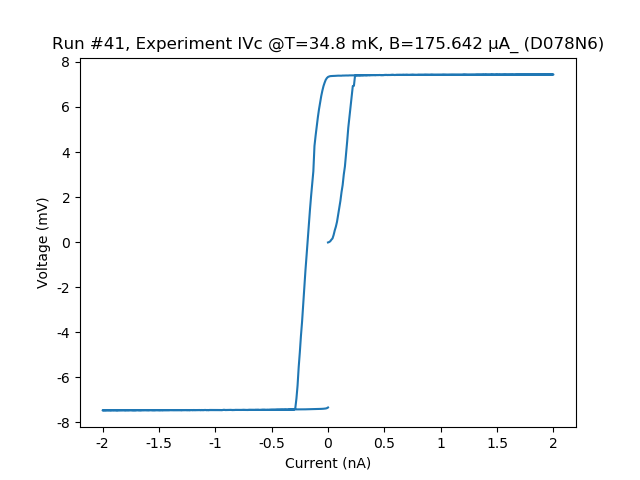

([<matplotlib.axes._subplots.AxesSubplot at 0x18a35830>], [None])

In [285]:
plot_by_id(41)

In [165]:
ZF = 0.0e-3
FF = 0.218e-3
# dF = 0.250e-3
# midF = 0.154e-3

keys  = [             'ids',          'T',  'B',                                 'comment'   ]
valss = [[range( 63,  90+1),        32e-3,  cos_to_B(np.linspace(0.375,0,16),    'fast 4'    ],
          
          
#          np.linspace(  0e-6,270e-6,28)
         [range( 91,  93+1),        32e-3,  np.linspace(230e-6,270e-6, 3),       'fast 6'    ],
         [range( 94, 118+1),        32e-3,  np.linspace(200e-6,260e-6,25),       'fast 4'    ],

         [range(164,177+1),        100e-3,  cos_to_B(np.linspace(1,0.35,14)),    'low F'     ],
   [selId(range(178,209+1)),       100e-3,  cos_to_B(np.linspace(0.375,0,16)),   'high F pos'],
   [selId(range(179,209+1),False), 100e-3,  cos_to_B(np.linspace(0.375,0,16)),   'high F neg'],
         
         [range(211,224+1),        200e-3,  cos_to_B(np.linspace(1,0.35,14)),    'low F'     ],
   [selId(range(225,256+1)),       200e-3,  cos_to_B(np.linspace(0.375,0,16)),   'high F pos'],
   [selId(range(226,256+1),False), 200e-3,  cos_to_B(np.linspace(0.375,0,16)),   'high F neg'],
         
        ]

exps78N6 = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]
exps78N6_pd = pd.DataFrame(  data  = list(zip(*valss)), index = keys ).transpose()## Run id matrix

<IPython.core.display.Javascript object>


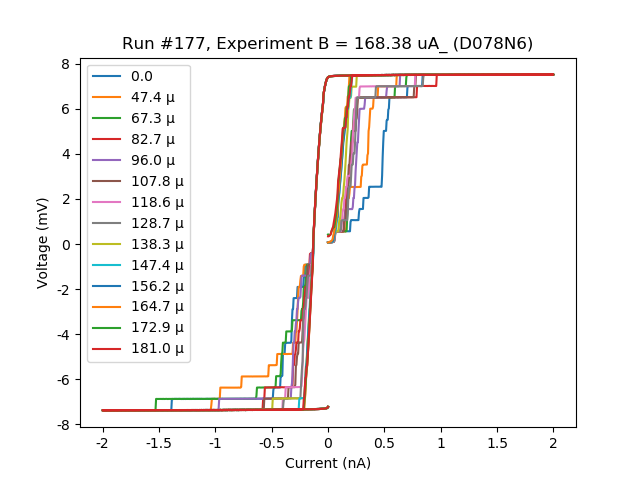

In [191]:
#100mK, low F
lbl = [si_format(i) for i in cos_to_B(np.linspace(1,0.35,14))]
batch_plot_by_id(range(164,177+1),
                labels = lbl)

# Measurement plan

<IPython.core.display.Javascript object>


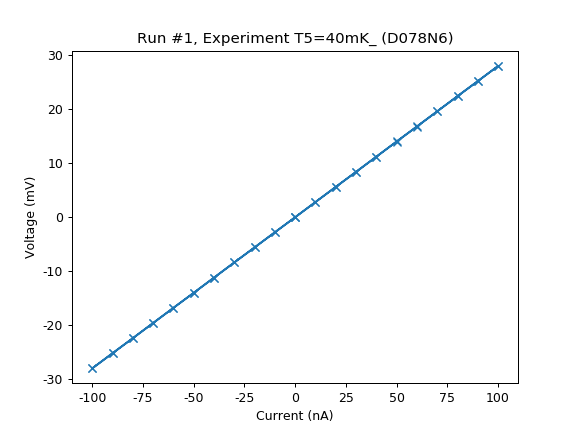

R_4pb = 280.0 kohm


In [19]:
plot_by_id(1, marker = 'x')
print('R_4pb = {}ohm'.format(si_format(np.polyfit(xy_by_id(1)[0],xy_by_id(1)[1],1)[0])))

<IPython.core.display.Javascript object>


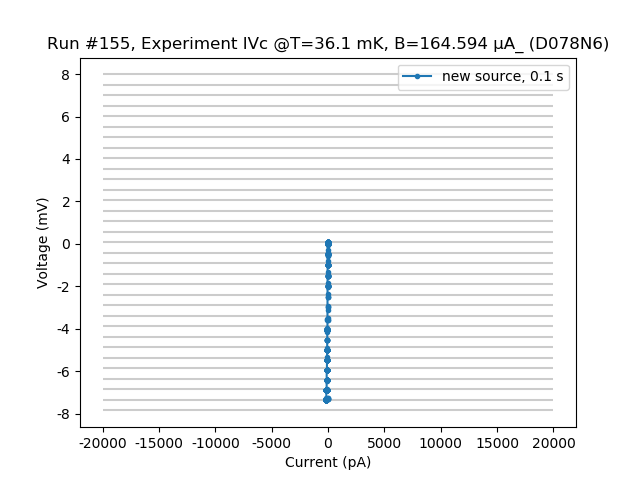

In [335]:
fig, ax = plt.subplots()

gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -20e-9,20e-9,
              alpha = 0.2)

#     ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
#               alpha = 0.1, color='r')

#     if i == 0:
#         ax.hlines( offset + fr*N, -1e-9,20e-9,
#                        alpha = 0.5, color='b')
#         ax.hlines( offset - fr*N, -1e-9,20e-9,
#                        alpha = 0.5, color='b')
#     else:
#         k = np.sign(i)*(N - abs(i))
#         ax.hlines( offset + gap*i + fr*k, -1e-9,20e-9,
#                        alpha = 0.5, color='b')  
        
ls = ['new source, 0.1 s',
      'Keith, 0.1 s',
      'Keith, 0.1 s']
batch_plot_by_id([152], ax = ax, marker = '.', labels = ls)

<IPython.core.display.Javascript object>


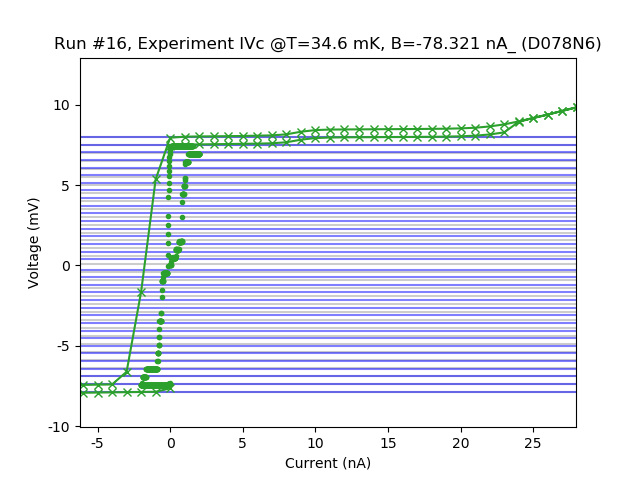

R_pos = 16.7 kohm/JJ, V_off = 126.6 µV/JJ
R_neg = 16.7 kohm/JJ, V_off = -114.8 µV/JJ
C/JJ from 1e/V_off : 19.2 yF


In [536]:
plt.close('all')
f,ax = plt.subplots()

I,V = xy_by_id(152)

ax.plot(I,V, marker = 'x', ls = '-', alpha = 1, color = 'C2')
plot_by_id(16, axes = ax, marker = '.', ls = 'None', alpha = 1, color = 'C2')

datSel = np.where(I > 50e-9, True, False)
a_p, b_p = np.polyfit(I[datSel], V[datSel], 1)
ax.plot(I[datSel], I[datSel]*a_p + b_p)

datSel = np.where(I < -50e-9, True, False)
a_n, b_n = np.polyfit(I[datSel], V[datSel], 1)
ax.plot(I[datSel], I[datSel]*a_n + b_n)

plot_Vg( ax, gap = 495e-6, offset = 68e-6, fr = 20e-6,N = 16, Irange = 1e-7)

print('R_pos = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_p/16), si_format(b_p/16)))
print('R_neg = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_n/16), si_format(b_n/16)))
print('C/JJ from 1e/V_off : {}F'.format(si_format(const.e/((a_p+b_p)/2/16))))

plt.show()

<IPython.core.display.Javascript object>


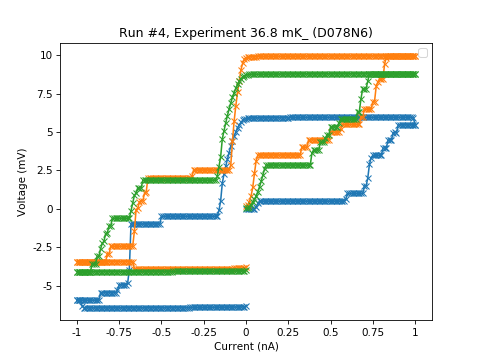

No handles with labels found to put in legend.


In [26]:
batch_plot_by_id([2,3,4], marker = 'x')#fast 4,6,4,

measure this device as we did in N0

<IPython.core.display.Javascript object>


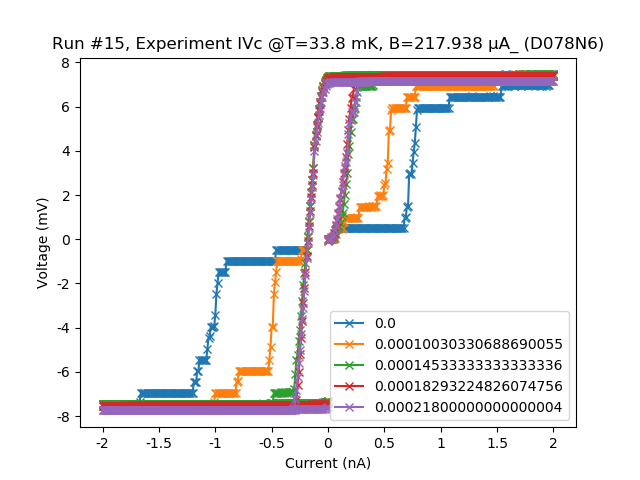

In [95]:
lbl = cos_to_B(np.linspace(1,0,5), ZF = 0e-6, FF = 218e-6)
batch_plot_by_id(range(11,15+1), marker = 'x', labels = lbl)

In [53]:
cos_to_B(np.append(np.linspace(1,0.25,11),
                   np.linspace(0.25,0,11)), 
                ZF = 0e-6, FF = 218e-6)

array([0.00000000e+00, 5.40922068e-05, 7.69984008e-05, 9.49389211e-05,
       1.10387924e-04, 1.24303146e-04, 1.37177680e-04, 1.49307352e-04,
       1.60888412e-04, 1.72061163e-04, 1.82932248e-04, 1.82932248e-04,
       1.86504140e-04, 1.90054921e-04, 1.93587250e-04, 1.97103667e-04,
       2.00606614e-04, 2.04098454e-04, 2.07581484e-04, 2.11057950e-04,
       2.14530061e-04, 2.18000000e-04])

<IPython.core.display.Javascript object>


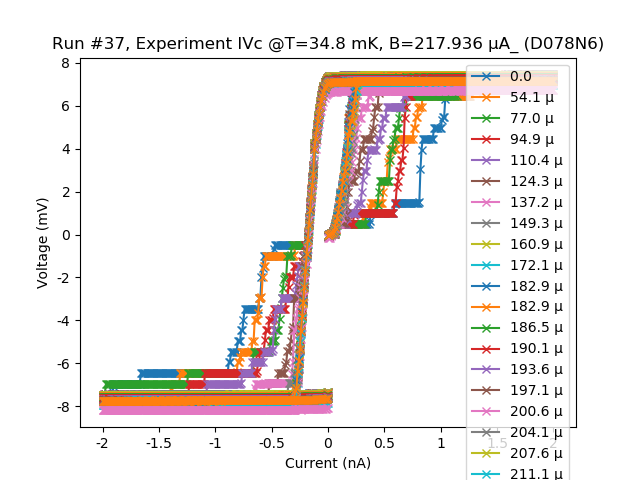

In [98]:
Blst = cos_to_B(np.append(np.linspace(1,0.25,11),
                          np.linspace(0.25,0,11)), 
                ZF = 0e-6, FF = 218e-6)

lbl = [si_format(l) for l in Blst]

batch_plot_by_id(range(1+15,22+15+1), marker = 'x', labels = lbl)

Seems to be in a reasonable agreement with N0, try smaller steps for higher frustration.
And analyze with fr_Vg resonance idea Kostya suggested.

<IPython.core.display.Javascript object>


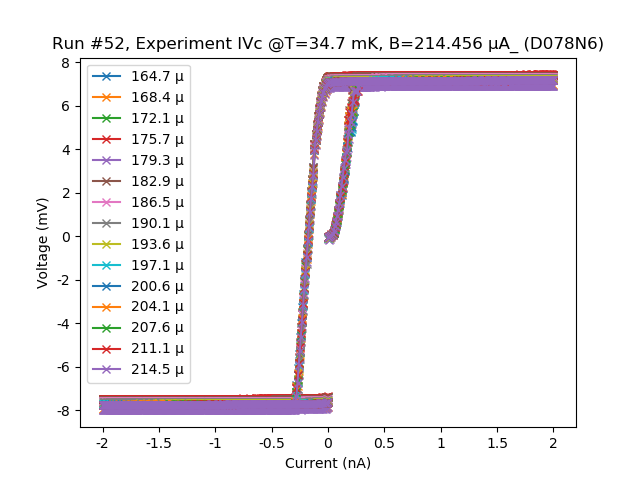

In [99]:
# a silly meas forgetting to set steps
Blst = cos_to_B(np.linspace(0.375,0,16), 
                ZF = 0e-6, FF = 218e-6)

lbl = [si_format(l) for l in Blst]

batch_plot_by_id(range(1+37,15+37+1), marker = 'x', labels = lbl)

to better access the Ic for Ic < 0.8nA, insert stabilize_I in between positive sweeping (0..1..0nA) and negative sweeping (0..-1..0nA) 

<IPython.core.display.Javascript object>


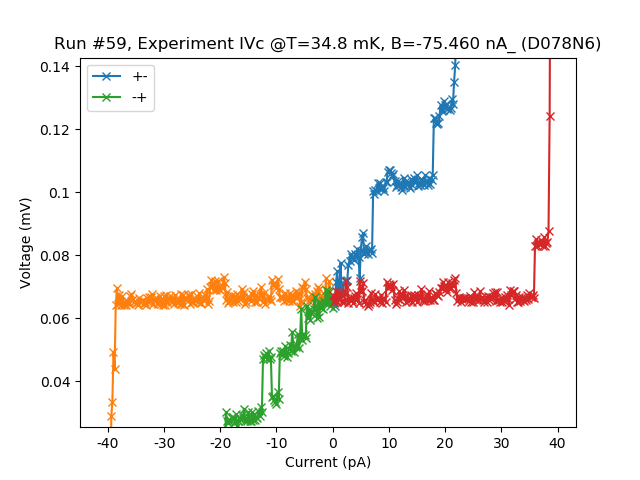

In [274]:
lbl = ['+-','','-+','']
batch_plot_by_id(range(1+55,4+55+1), marker = 'x', labels = lbl)

> **why the Ic depends on stabilization? let's do first in both way tonight and check this issue tmr**

<IPython.core.display.Javascript object>


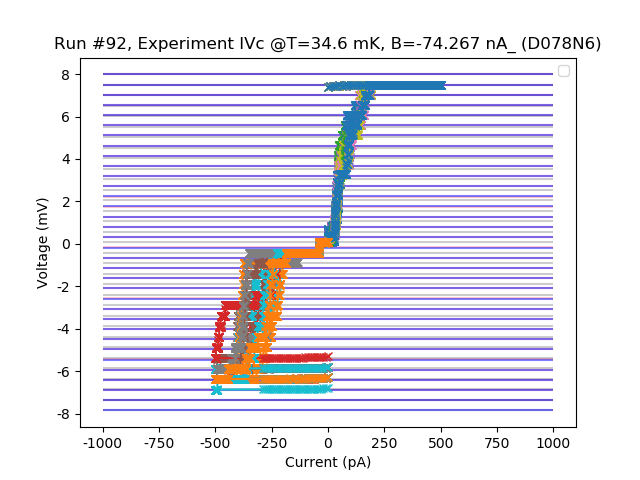

No handles with labels found to put in legend.


In [326]:
Blst = cos_to_B(np.linspace(0.375,0,16), 
                ZF = 0e-6, FF = 218e-6)
lbl = [si_format(l) for l in Blst]

plt.close('all')
f,ax = plt.subplots()
batch_plot_by_id(range(1+60,32+60+1), ax = ax, marker = 'x')#, labels = lbl)

gap = 495e-6
offset = 68e-6
fr = 16e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

    ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
              alpha = 0.2, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  
plt.show()

hmm... for some reason the negative sweep aligns with (N x Vg + Voff) better for +- scan (udu direction), check -+

<IPython.core.display.Javascript object>


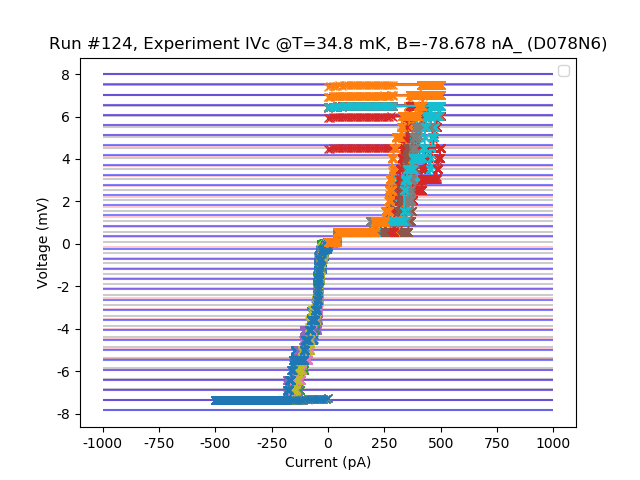

No handles with labels found to put in legend.


In [331]:
Blst = cos_to_B(np.linspace(0.375,0,16), 
                ZF = 0e-6, FF = 218e-6)

lbl = [si_format(l) for l in Blst]


plt.close('all')
f,ax = plt.subplots()
batch_plot_by_id(range(1+92,32+92+1), ax = ax, marker = 'x')#, labels = lbl)

gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

    ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
              alpha = 0.2, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  
plt.show()

It seems like we can "control" the alignment to either 
1. (N x Vg) by some preparation, or 
2. (N x Vg + k x fr) from system being idle. 

By preparation I mean doing this

    stabilize_I(i_stb = -100e-12)
    IVC_cust (i_list = ni_list, Gain=100, R_bias=50, Attn=1, tfsstb = 0.1)
    stabilize_I(i_stb = 100e-12)
    IVC_cust (i_list = pi_list, Gain=100, R_bias=50, Attn=1, tfsstb = 0.1)

Why?!
- Is it related to the state prep (stabilize_I)?
- Or it's related to the last state the system was (step size used in the last scan)?

Also one observation:
- Such alignment seems to be associated with I_SW. larger I_SW tends to align with (N x Vg).

<IPython.core.display.Javascript object>


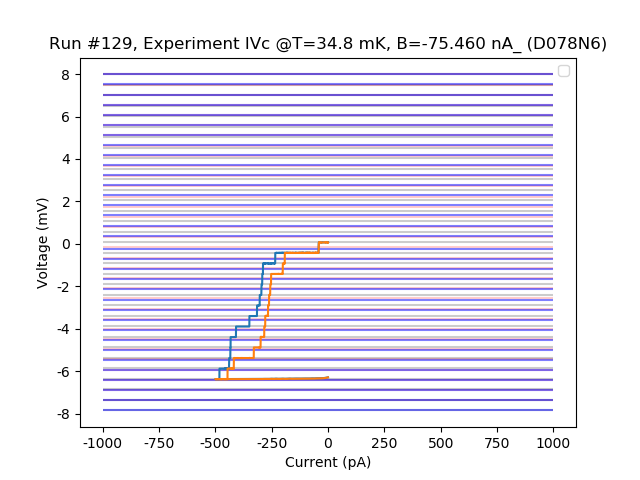

No handles with labels found to put in legend.


In [519]:
#procedure: stabilize_I(-100pA) > IVC_cust(ni_list)
#                               > stabilize_I(-100pA) > IVC_cust(ni_list)
plt.close('all')
f,ax = plt.subplots()
batch_plot_by_id([128,129], ax =ax)

gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

    ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
              alpha = 0.2, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  

ok... so it's consistent at least:

Repeating same scan gives same results, which means it neither 
- swap to align with (N x Vg + k x fr), nor
- has larger I_SW

<IPython.core.display.Javascript object>


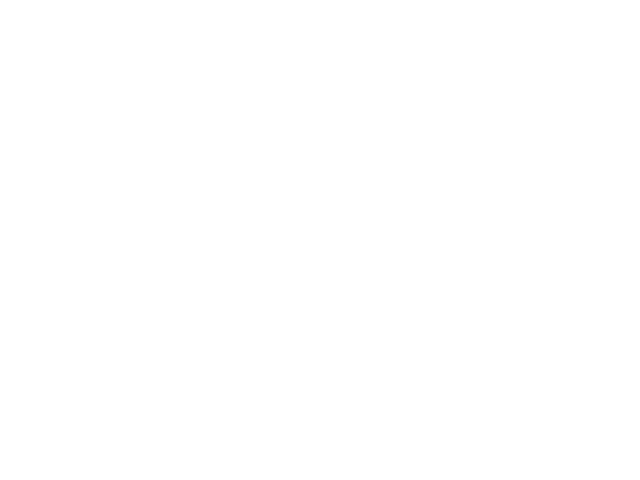

No handles with labels found to put in legend.


In [329]:
#procedure: stabilize_I(-100pA) > IVC_cust(ni_list)
#                               > stabilize_I(+100pA) > IVC_cust(pi_list)
#                               > stabilize_I(-100pA) > IVC_cust(ni_list)
plt.close('all')
f,ax = plt.subplots()
batch_plot_by_id([130,131,132], ax =ax)

gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

    ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
              alpha = 0.2, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  

Uh... so how can I trigger back to where we saw the state with (N x Vg + k x fr) + larger I_SW?

Repeating same scan gives same results, which means it neither 
- swap to align with (N x Vg + k x fr), nor
- has larger I_SW

In [ ]:
Blst = cos_to_B(np.linspace(0.375,0,16), 
                ZF = 0e-6, FF = 218e-6)

lbl = [si_format(l) for l in Blst]

batch_plot_by_id(range(93,124+1), marker = 'x', labels = lbl)

Kostya pointed out that the  

<IPython.core.display.Javascript object>


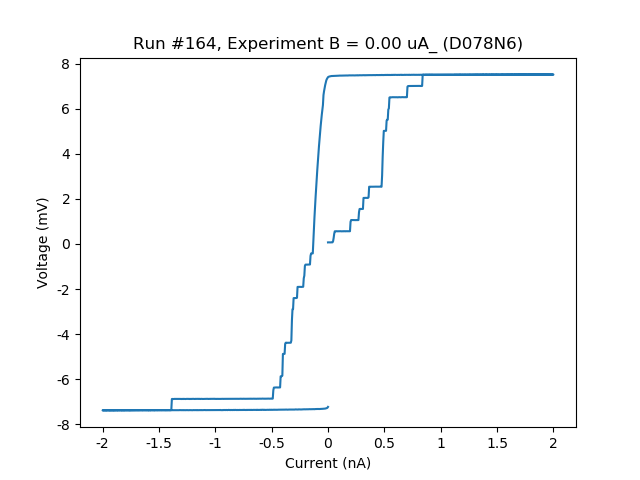

([<matplotlib.axes._subplots.AxesSubplot at 0x496e050>], [None])

In [46]:
plot_by_id(164)

<IPython.core.display.Javascript object>


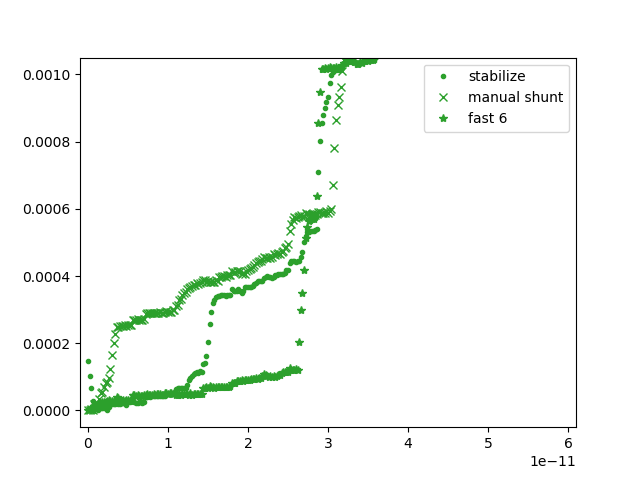

In [211]:
a = [61, 69, 73, 75, 81]
b = range(133,137+1)
c = range(138,142+1)
d = [[a[i],b[i],c[i]] for i in range(0,4+1)]
colorlst = ['C1','C2','C3','C4','C5']
markerlst = ['.', 'x', '*']

Blst = cos_to_B(np.linspace(0.375,0,16), 
                ZF = 0e-6, FF = 218e-6)
idxlst = [0,4,6,7,10]
extBlst = [Blst[i] for i in idxlst]
lbl = ['stabilize','manual shunt','fast 6']

plt.close('all')
f,ax = plt.subplots()

# for i,v in enumerate(d):
#     for j,w in enumerate(v):
#         ax.plot(xy_by_id(w)[0], 
#                 xy_by_id(w)[1]-xy_by_id(w)[1][:100].min(), 
#                 color = colorlst[i],
#                 marker = markerlst[j],
#                 ls = 'None',
#                 label = lbl[i])

for j,w in enumerate(d[1]):
    ax.plot(xy_by_id(w)[0], 
            xy_by_id(w)[1]-xy_by_id(w)[1][:100].min(), 
            color = colorlst[1],
            marker = markerlst[j],
            ls = 'None',
            label = lbl[j])
ax.set_xlim(-1e-12,61e-12)
ax.set_ylim(-50e-6,1050e-6)
ax.legend()
plt.show()

try to compare different sources at high F point

<IPython.core.display.Javascript object>


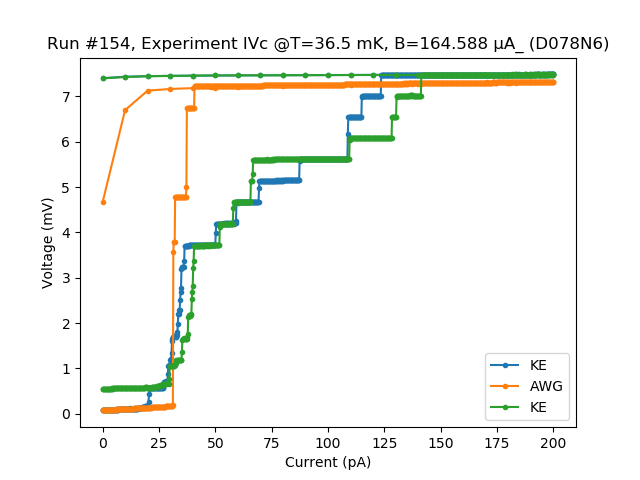

In [210]:
lbl = ['KE', 'AWG', 'KE']
batch_plot_by_id([149,153,154],marker = '.', ls='-', labels = lbl)

<IPython.core.display.Javascript object>


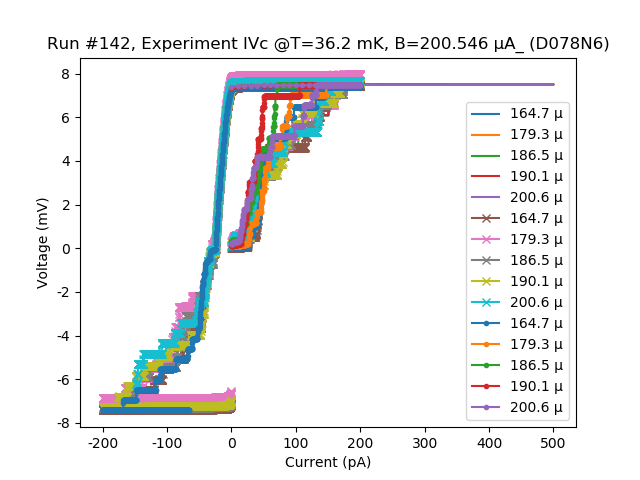

In [207]:
Blst = cos_to_B(np.linspace(0.375,0,16), 
                ZF = 0e-6, FF = 218e-6)
idxlst = [0,4,6,7,10]
extBlst = [Blst[i] for i in idxlst]
lbl = [si_format(l) for l in extBlst]
colorlst = ['C0','C1','C2','C3','C4']

plt.close('all')
f,ax = plt.subplots()
batch_plot_by_id(np.array(idxlst)*2+61, ax=ax, labels = lbl)
batch_plot_by_id(range(133,137+1), ax=ax, labels = lbl, marker = 'x')
batch_plot_by_id(range(138,142+1), ax=ax, labels = lbl, marker = '.')
plt.show()

kk: after IVC_cust is done, the cleanup procedure is called, which sets B to zero - misinterpretation of B in the curves

what typer of meas is that?? need to log stuff!!

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


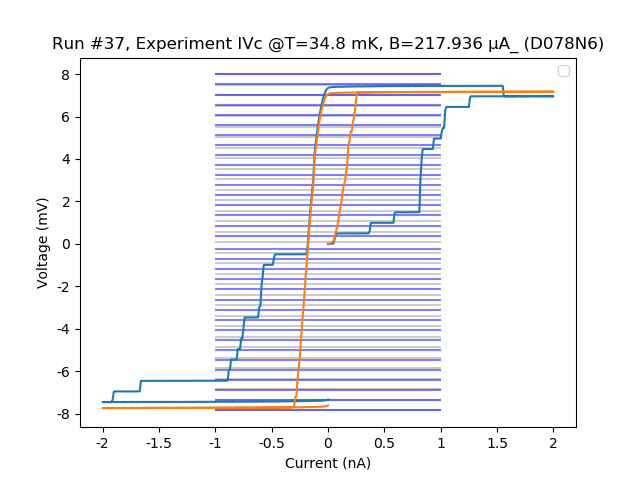

No handles with labels found to put in legend.


In [516]:
f, ax = plt.subplots()

batch_plot_by_id([16,37], ax=ax)    
plot_Vg( ax, gap = 495e-6, offset = 68e-6, fr = 20e-6,N = 16)

<IPython.core.display.Javascript object>


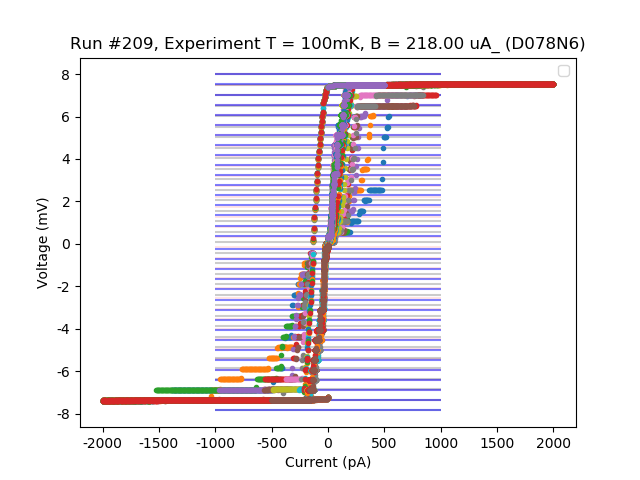

No handles with labels found to put in legend.


In [337]:
fig, ax = plt.subplots()


batch_plot_by_id(range(164,209+1),marker = '.', ls ='',  ax = ax)


gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

    ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
              alpha = 0.1, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  

## 2/5, T-dep meas

T is set to 100mK and 200mK to collect more data for future records

<IPython.core.display.Javascript object>


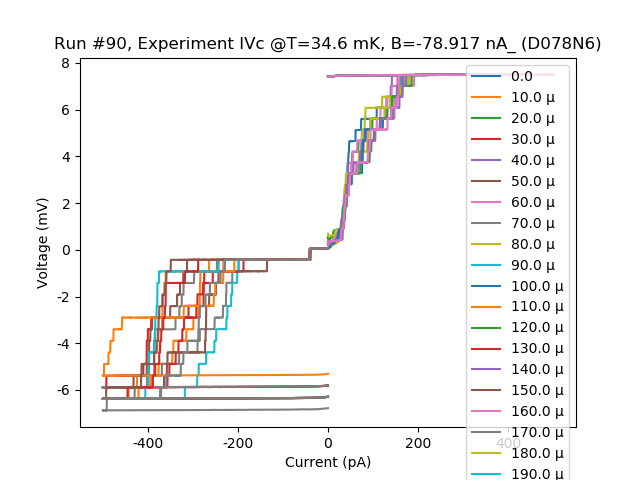

In [201]:
#32mK, low F
lbl = [si_format(B) for B in np.linspace(  0e-6,270e-6,28)]
batch_plot_by_id(range(63,90+1),
                labels = lbl)

<IPython.core.display.Javascript object>


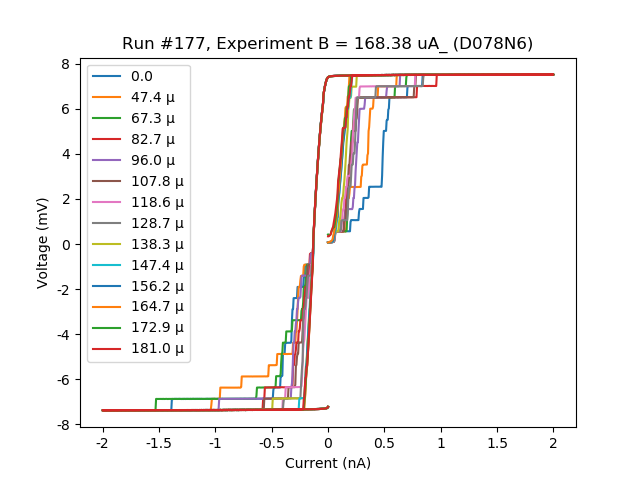

In [195]:
#100mK, low F
lbl = [si_format(B) for B in cos_to_B(np.linspace(1,0.35,14))]
batch_plot_by_id(range(164,177+1),
                labels = lbl)

<IPython.core.display.Javascript object>


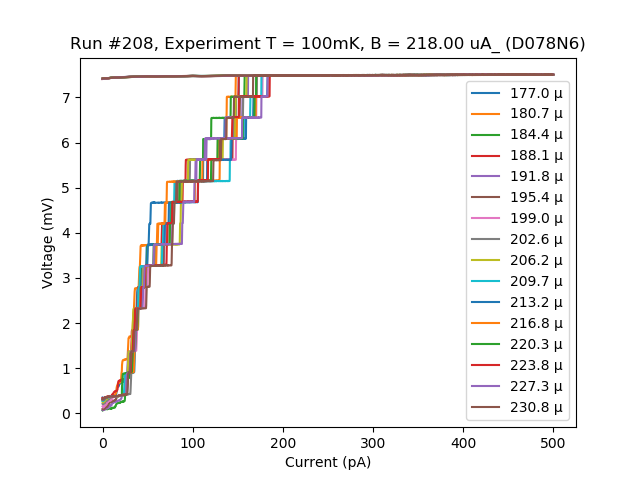

In [318]:
#100mK, high F, pos scan
lbl = [si_format(B) for B in cos_to_B(np.linspace(0.375,0,17))]
batch_plot_by_id(selId(range(178,209+1)),
                labels = lbl)

<IPython.core.display.Javascript object>


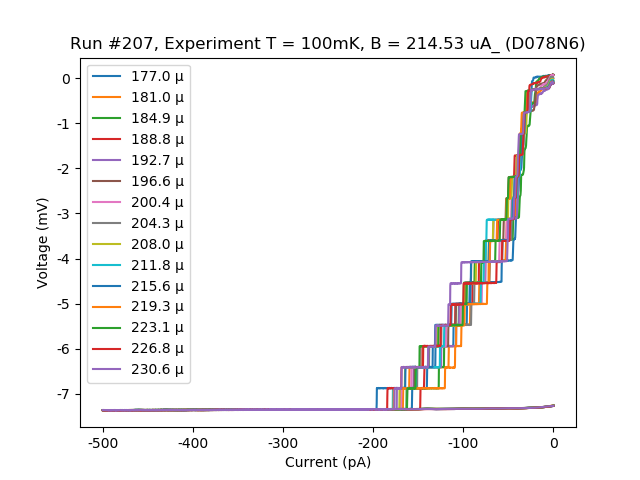

In [199]:
#100mK, high F, neg scan
lbl = [si_format(B) for B in cos_to_B(np.linspace(0.375,0,16))]
batch_plot_by_id(selId(range(179,209+1),False),
                labels = lbl)

<IPython.core.display.Javascript object>


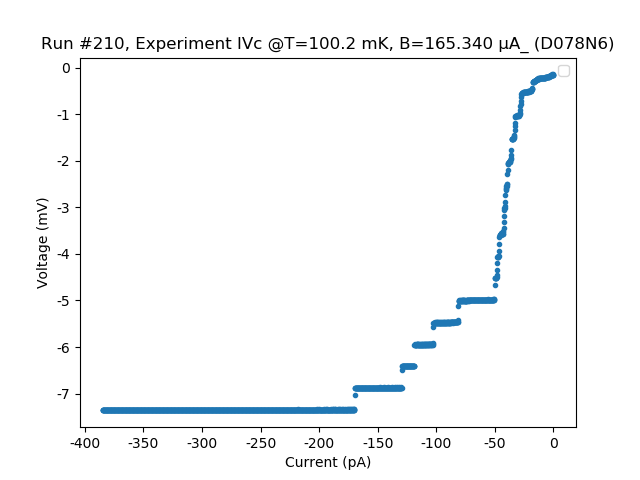

No handles with labels found to put in legend.


In [55]:
batch_plot_by_id([210], marker = '.', ls = '')

<IPython.core.display.Javascript object>


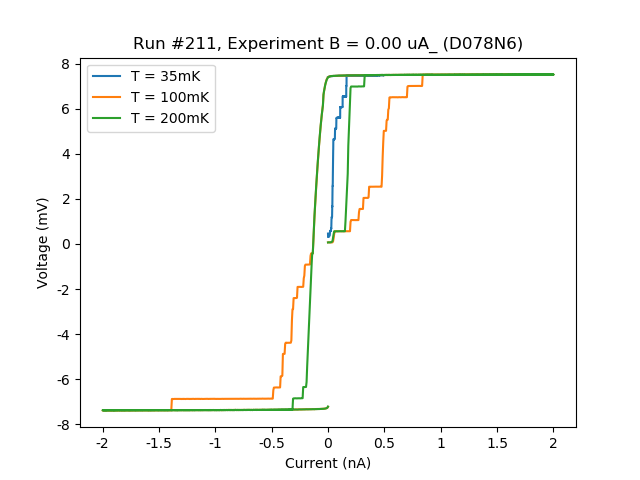

In [212]:
lbl = ['T = 35mK', 'T = 100mK', 'T = 200mK']
batch_plot_by_id([63,164,211], labels = lbl)

Depends on where the resonance occurs, it's possible that the resonance might "feel" the environmental impedance if the resonance is 

<IPython.core.display.Javascript object>


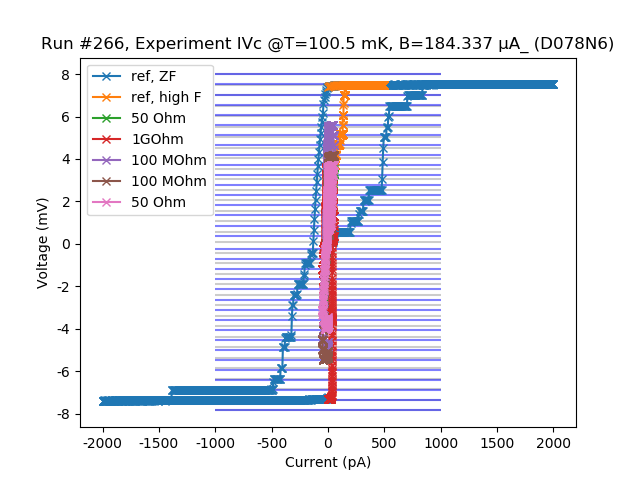

In [336]:
fig, ax = plt.subplots()

lbl = 'ref, ZF', 'ref, high F', '50 Ohm', '1GOhm', '100 MOhm', '100 MOhm', '50 Ohm'
batch_plot_by_id ([164, 180, 262, 263, 264, 265, 266], ax = ax, labels = lbl, marker = 'x')


gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

#     ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
#               alpha = 0.1, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  

<IPython.core.display.Javascript object>


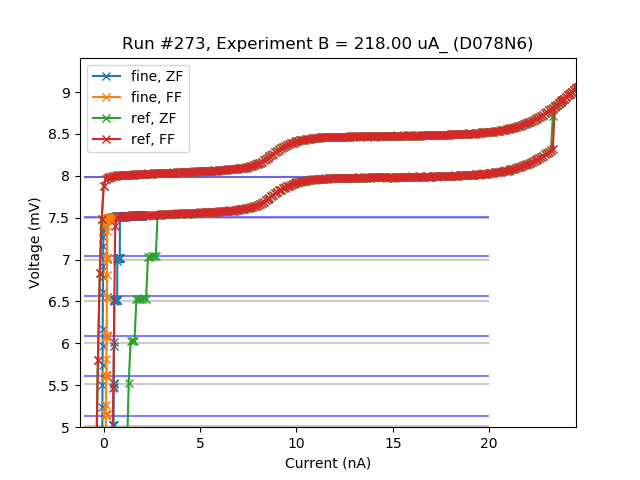

In [540]:
fig, ax = plt.subplots()

lbl = 'fine, ZF', 'fine, FF', 'ref, ZF', 'ref, FF'
batch_plot_by_id ([164, 198, 272, 273], ax = ax, labels = lbl, marker = 'x')


gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,20e-9,
              alpha = 0.2)

#     ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
#               alpha = 0.1, color='r')

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,20e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,20e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,20e-9,
                       alpha = 0.5, color='b')  

In [539]:
7.984-7.507

0.4770000000000003

## K6220 investigation

V across 1 MOhm resistor vs I set, sample is shunted

<IPython.core.display.Javascript object>


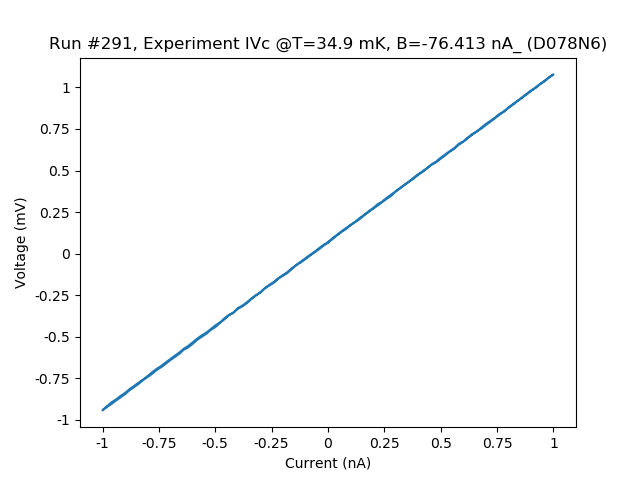

([<matplotlib.axes._subplots.AxesSubplot at 0x21630f10>], [None])

In [389]:
plot_by_id(291)

set to 1nA, back to 0, meas with time

<IPython.core.display.Javascript object>


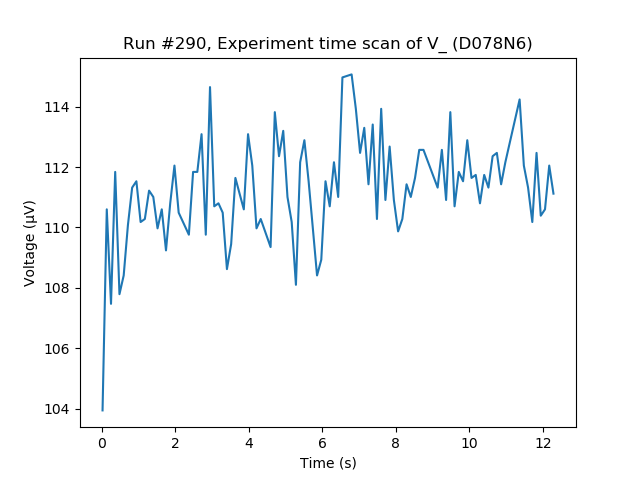

([<matplotlib.axes._subplots.AxesSubplot at 0x18fc20f0>], [None])

In [371]:
plot_by_id(290)

no delay between set I to 0 and zero V across resisitor was observed *maybe was shunted by preamp

We disconnected everything back and forth, lets check IVc again

<IPython.core.display.Javascript object>


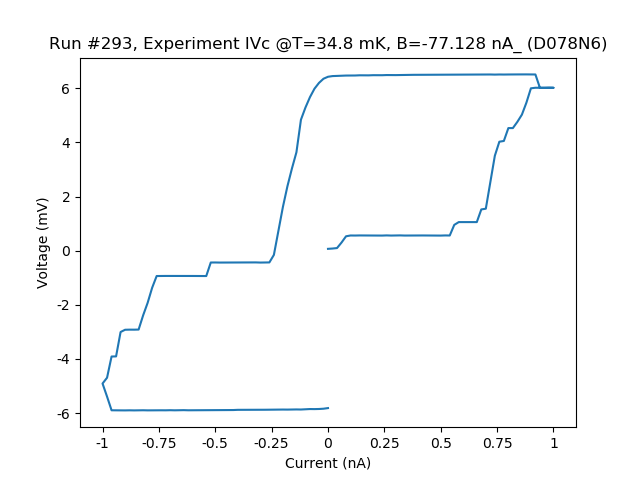

([<matplotlib.axes._subplots.AxesSubplot at 0x1b877690>], [None])

In [372]:
plot_by_id(293)

nope, IVc still has this overshooting

chech decay measuring V across junction

<IPython.core.display.Javascript object>


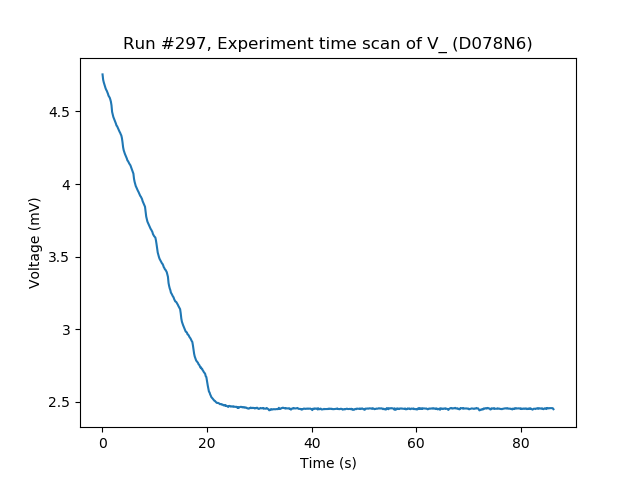

([<matplotlib.axes._subplots.AxesSubplot at 0x1bba1c70>], [None])

In [375]:
plot_by_id(297)

Can see decay now, was need to introduce sleep(1) netween set 0 and set 1

repeat with V across load R

<IPython.core.display.Javascript object>


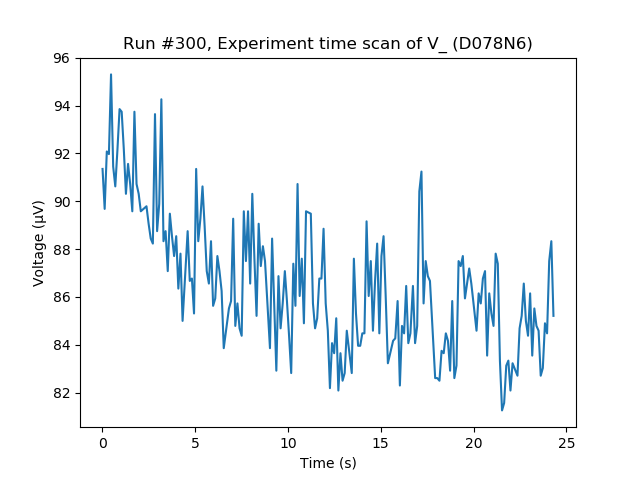

([<matplotlib.axes._subplots.AxesSubplot at 0x1f129950>], [None])

In [380]:
plot_by_id(300)

<IPython.core.display.Javascript object>


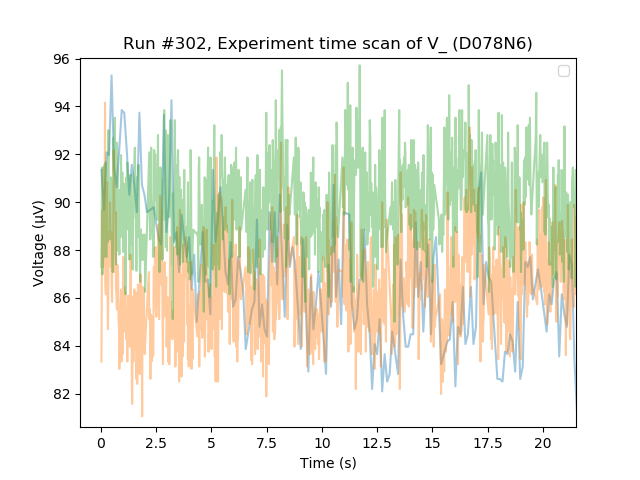

No handles with labels found to put in legend.


In [385]:
batch_plot_by_id([300, 301, 302],alpha = 0.4)

IVc_udu, but measuring V across R = 1 MOhm

<IPython.core.display.Javascript object>


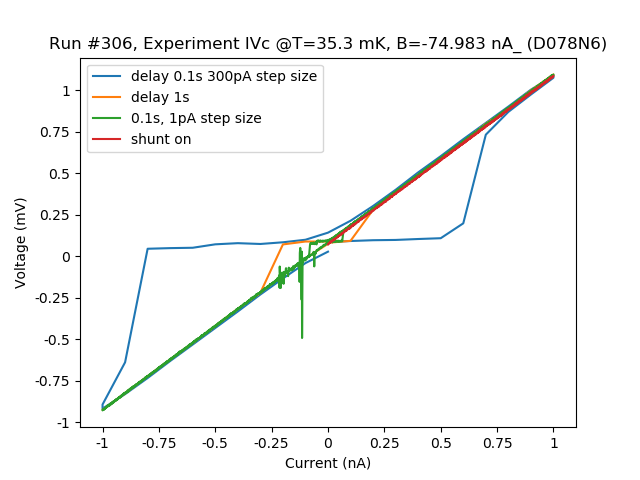

In [410]:
lbl = ['delay 0.1s 300pA step size', 'delay 1s', '0.1s, 1pA step size', 'shunt on']
batch_plot_by_id([303,304, 305, 306], labels = lbl)

<IPython.core.display.Javascript object>


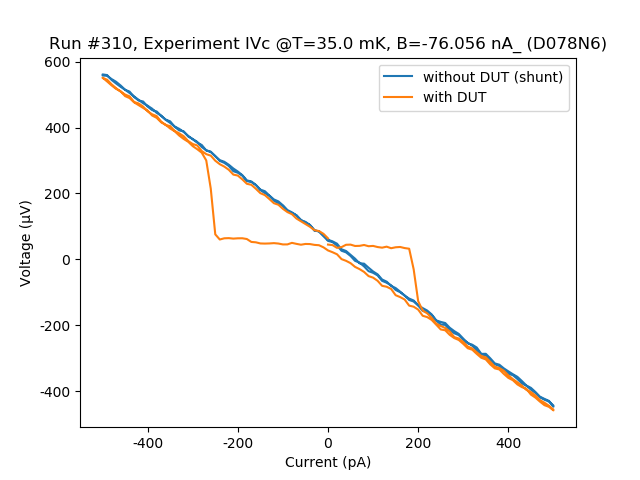

In [448]:
lbl = ['without DUT (shunt)', 'with DUT']
batch_plot_by_id([309,310], labels = lbl)

This IVc for load R is bizzarre - why it knows the voltage drop on DUT?

<IPython.core.display.Javascript object>


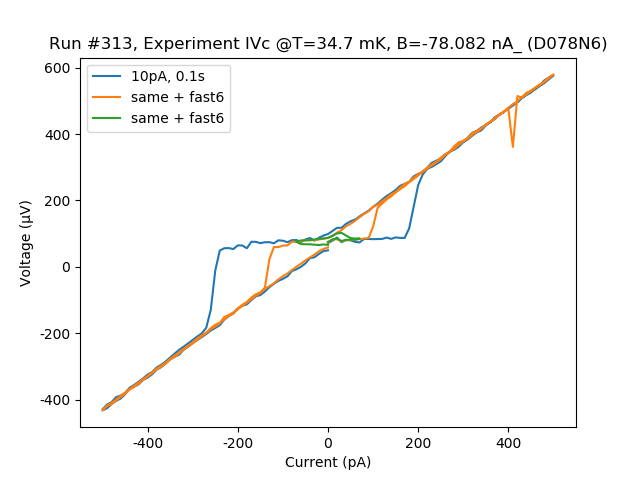

In [449]:
lbl = ['10pA, 0.1s', 'same + fast6', 'same + fast6']
batch_plot_by_id([311, 312,313], labels = lbl)

plot with "true current" converted from voltage-drop across load R measurement

<IPython.core.display.Javascript object>


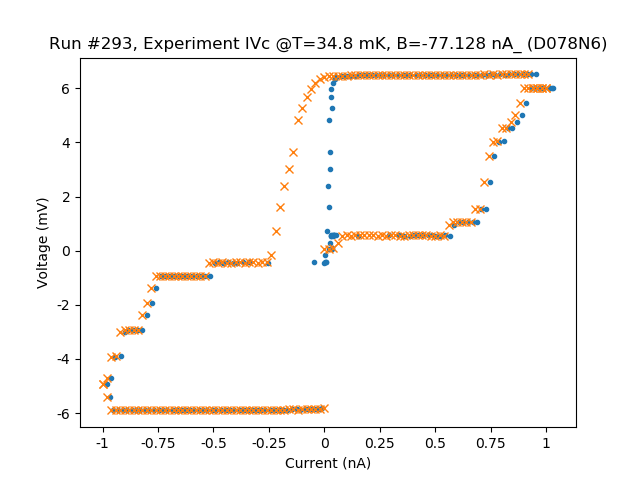

([<matplotlib.axes._subplots.AxesSubplot at 0x27f94290>], [None])

In [450]:
I = (xy_by_id(317)[1]-51.75e-6)/1E6
V = xy_by_id(293)[1]
f,ax=plt.subplots()
ax.plot(I,V, '.')

# ax2 = ax.twiny()
plot_by_id(293, axes=ax, ls = 'None', marker = 'x', color ='C1')


<IPython.core.display.Javascript object>


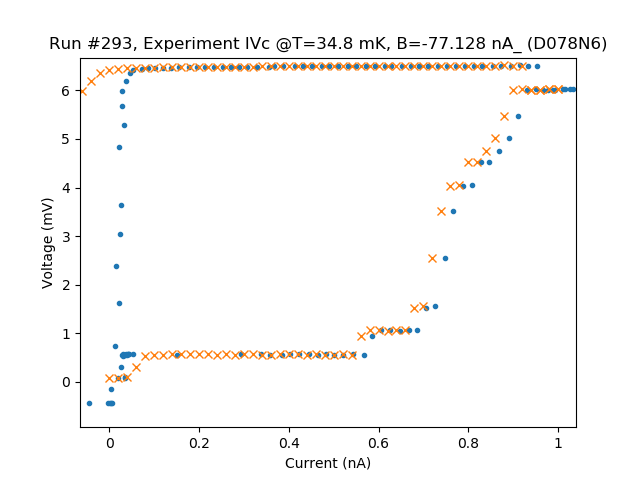

([<matplotlib.axes._subplots.AxesSubplot at 0x1f9d3c90>], [None])

In [439]:
I = (xy_by_id(317)[1]-51.75e-6)/1E6
V = xy_by_id(293)[1]
f,ax=plt.subplots()
ax.plot(I,V, '.')

# ax2 = ax.twiny()
plot_by_id(293, axes=ax, ls = 'None', marker = 'x', color ='C1')


so the take away from here is that our IVc measurement is reliable except when the retrapping is swept just across zero. And all switching current are subjected to ~20pA shifts.

### turn off MW

it turns out that MW was on all the way, so check if it affects our DC meas

In [535]:
def plot_Vg( ax, gap = 495e-6, offset = 68e-6, fr = 20e-6,N = 16, Irange=1e-9 ):


    for i in range(-N,N+1,1):
        ax.hlines(i*gap  +offset,                   -1*Irange,Irange,
                  alpha = 0.2)

        if i == 0:
            ax.hlines( offset + fr*N, -1*Irange,Irange,
                           alpha = 0.5, color='b')
            ax.hlines( offset - fr*N, -1*Irange,Irange,
                           alpha = 0.5, color='b')
        else:
            k = np.sign(i)*(N - abs(i))
            ax.hlines( offset + gap*i + fr*k, -1*Irange,Irange,
                           alpha = 0.5, color='b') 

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


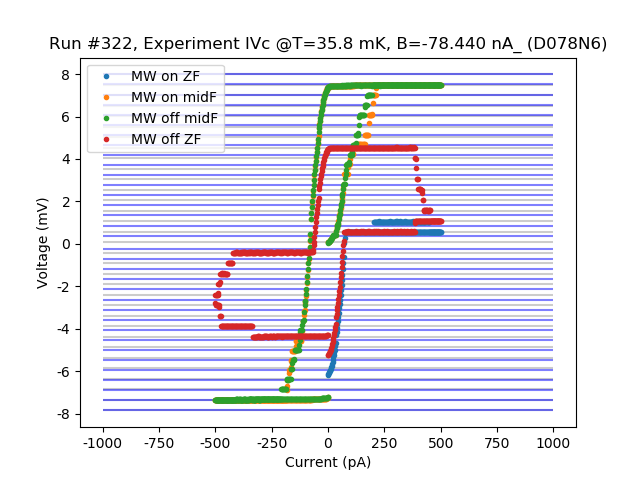

In [511]:
f, ax = plt.subplots()
#midF = 180e-6
lbl = ['MW on ZF','MW on midF', 'MW off midF', 'MW off ZF']
batch_plot_by_id([320, 319, 321, 322], ax = ax, ls = '', marker = '.', labels = lbl)


gap = 495e-6
offset = 68e-6
fr = 20e-6
N = 16

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -1e-9,1e-9,
              alpha = 0.2)

    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.5, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.5, color='b')  

ok, so disconnecting MW sources doesn't help to eliminate the sub-gap shifts due to unknown fr. what else?

### ZF true I

Next let's see if the IVc has smooth transition across zero by setting up udu x2

<IPython.core.display.Javascript object>


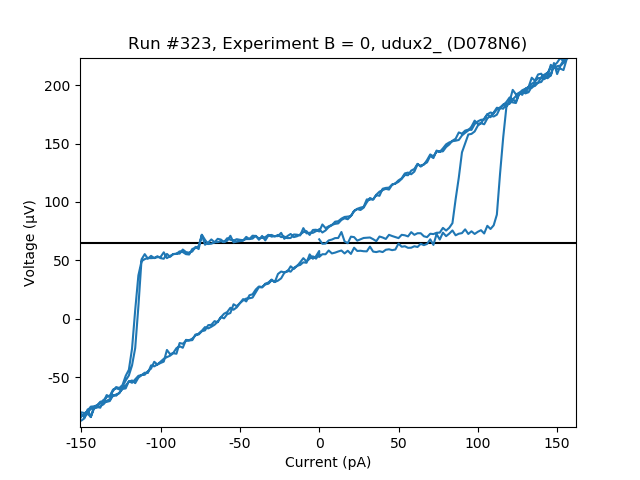

In [459]:
f, ax = plt.subplots()

plot_by_id(323, axes = ax)


off = 65e-6
ax.hlines(off, -500e-12, 500e-12)

<IPython.core.display.Javascript object>


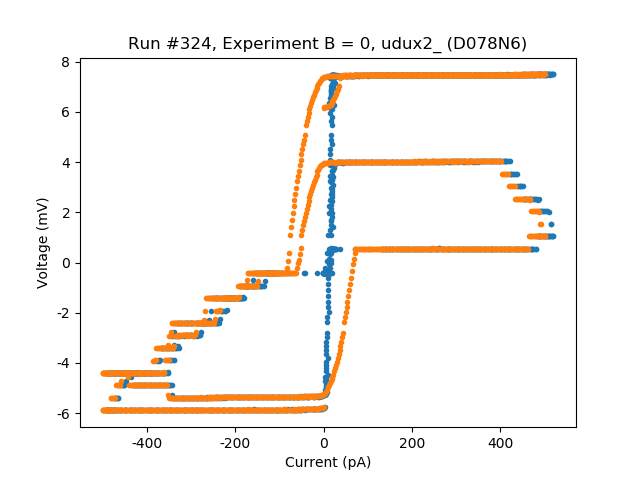

([<matplotlib.axes._subplots.AxesSubplot at 0x22791e90>], [None])

In [475]:
#ZF data

I = (xy_by_id(323)[1]-51.75e-6)/1E6
V = xy_by_id(324)[1]
f,ax=plt.subplots()
ax.plot(I,V, '.')

plot_by_id(324, axes=ax, ls = 'None', marker = '.', color ='C1')


### FF trueI

<IPython.core.display.Javascript object>


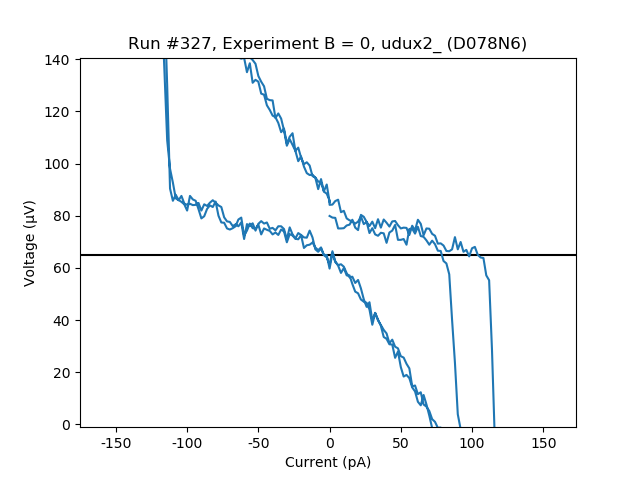

In [471]:
#B = FF, not 0!
f, ax = plt.subplots()

plot_by_id(327, axes = ax)


off = 65e-6
ax.hlines(off, -500e-12, 500e-12)

<IPython.core.display.Javascript object>


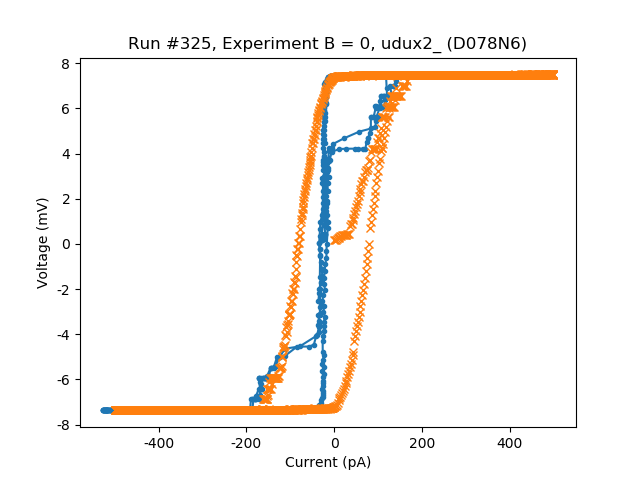

([<matplotlib.axes._subplots.AxesSubplot at 0x276832b0>], [None])

In [465]:
#FF data

I = (xy_by_id(327)[1]-51.75e-6)/-1E6
V = xy_by_id(325)[1]
f,ax=plt.subplots()
ax.plot(I,V, '.',ls = '-' )

plot_by_id(325, axes=ax, ls = 'None', marker = 'x', color ='C1')


### 180uA, true I 

<IPython.core.display.Javascript object>


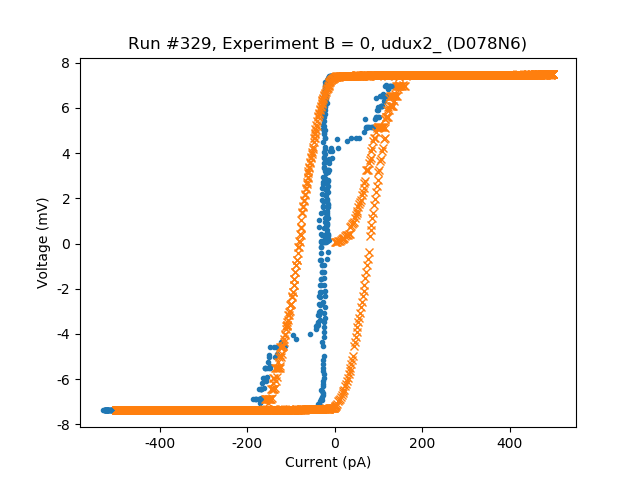

([<matplotlib.axes._subplots.AxesSubplot at 0x1fb983f0>], [None])

In [468]:
#midF data

I = (xy_by_id(328)[1]-51.75e-6)/-1E6
V = xy_by_id(329)[1]
f,ax=plt.subplots()
ax.plot(I,V, '.', )

plot_by_id(329, axes=ax, ls = 'None', marker = 'x', color ='C1')


<IPython.core.display.Javascript object>


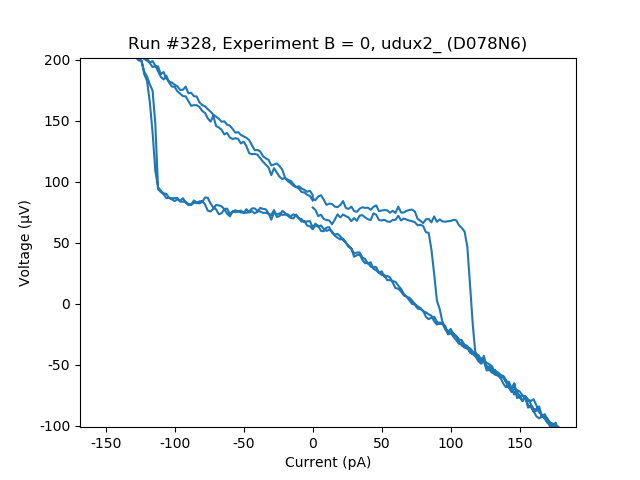

([<matplotlib.axes._subplots.AxesSubplot at 0x234cd410>], [None])

In [466]:
plot_by_id(328)

### Diff baising scheme

Probably, we have these issues with I settling due to capacitances of the lines in the fridge. Manual says the settling time in us is 10e6*Rload*Cload


shunt Isrc with R = 10 kOhm (allows currents up to 2mA), after that connect filter(3MOhm) to this R => have a current devider with 10/2000 = 1/300 attenuation. Hopefully this will help source not to feel 'bad impedance' of the JJ

<IPython.core.display.Javascript object>


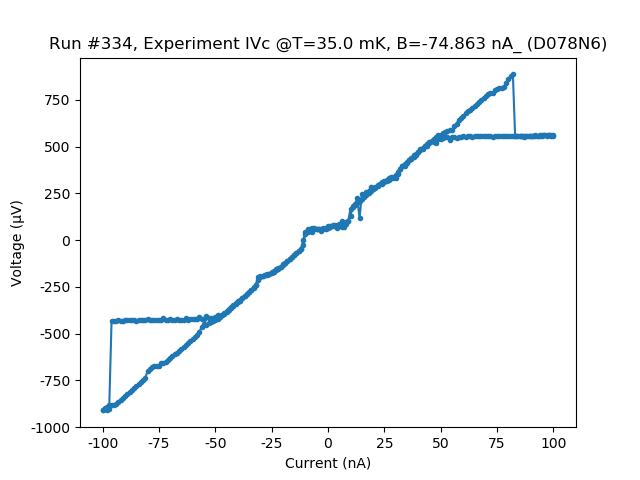

([<matplotlib.axes._subplots.AxesSubplot at 0x2a2a9710>], [None])

In [482]:
plot_by_id(334, marker = '.')

<IPython.core.display.Javascript object>


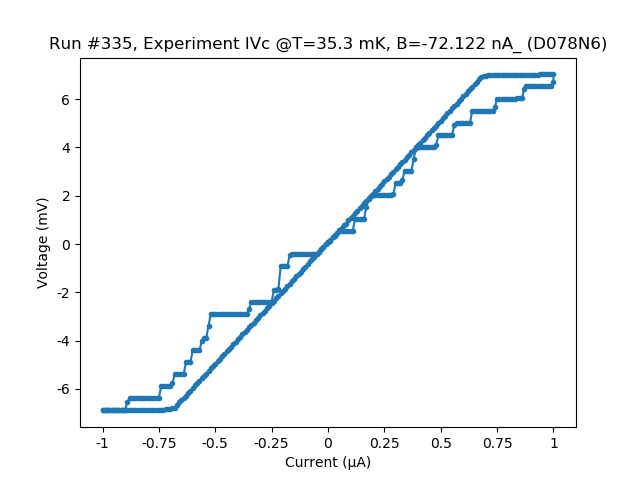

([<matplotlib.axes._subplots.AxesSubplot at 0x284e8270>], [None])

In [485]:
plot_by_id(335, marker = '.')

correction by I_true throu the jj

<IPython.core.display.Javascript object>


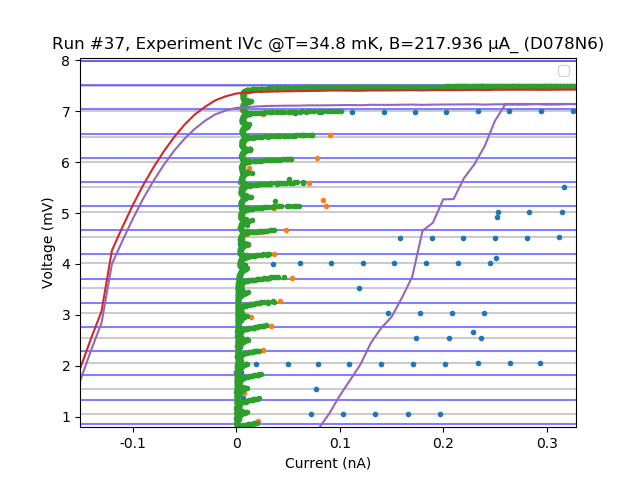

No handles with labels found to put in legend.


In [518]:
f, ax = plt.subplots()

R = 3.2e6
r = 10.1e3

for idx in [335, 336, 337]:
    I, V = xy_by_id(idx)
    It = (I*r-(V-68e-6))/(r+R)

    ax.plot(It, V, marker = '.', ls = '')
batch_plot_by_id([16,37], ax = ax )    
plot_Vg( ax, gap = 495e-6, offset = 68e-6, fr = 20e-6,N = 16)


C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


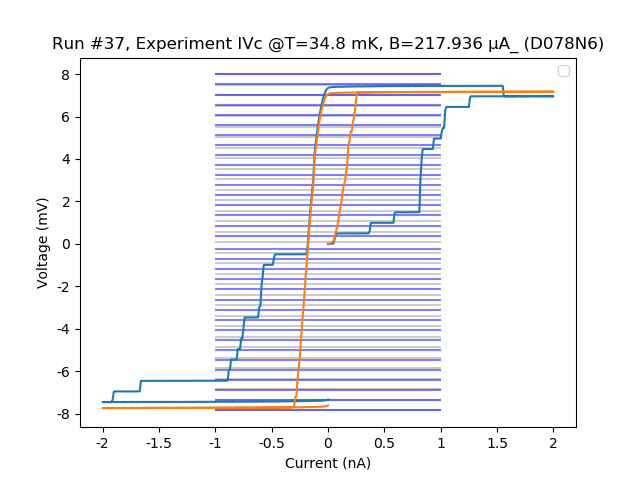

No handles with labels found to put in legend.


In [516]:
f, ax = plt.subplots()

batch_plot_by_id([16,37], ax=ax)    
plot_Vg( ax, gap = 495e-6, offset = 68e-6, fr = 20e-6,N = 16)